## Exercice 2.1 - Quantile estimation with simulated data
### Statistical learning with extremes

_Benjamin Lapostolle + Mehdi-Lou Pigeard_

_________________

In [1]:
install.packages("evd")
library(evd)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("SpatialExtremes")
install.packages("extRemes")
library(SpatialExtremes)
library(extRemes)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘Rcpp’, ‘spam’, ‘maps’, ‘fields’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppArmadillo’, ‘Lmoments’, ‘distillery’



Attaching package: ‘SpatialExtremes’


The following objects are masked from ‘package:evd’:

    dgev, dgpd, pgev, pgpd, profile2d, qgev, qgpd, rgev, rgpd


Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:evd’:

    fbvpot, mrlplot


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




In [3]:
install.packages("actuar")
library(actuar)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘expint’



Attaching package: ‘actuar’


The following objects are masked from ‘package:evd’:

    dgumbel, pgumbel, qgumbel, rgumbel


The following objects are masked from ‘package:stats’:

    sd, var


The following object is masked from ‘package:grDevices’:

    cm




## 0. Data Generation
We generate our dataset out of independent data from a Fréchet distribution

In [4]:
shape_real <- 1/3
loc_real <- 1
scale_real <- 1/3
n <- 1e5

samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)
zoomed_samples <- samples[samples < 10]

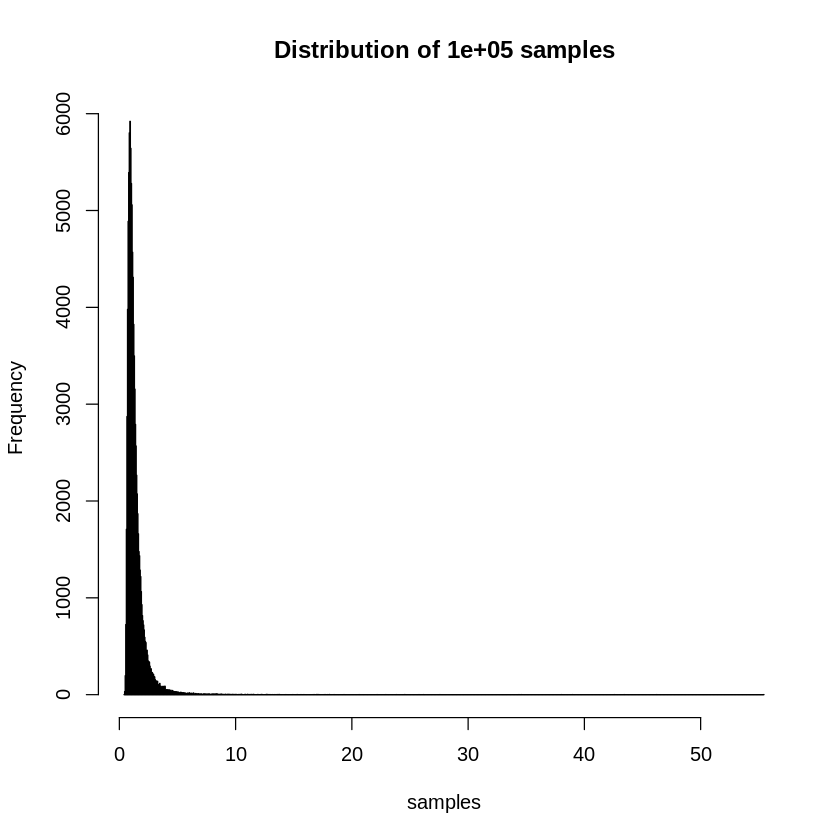

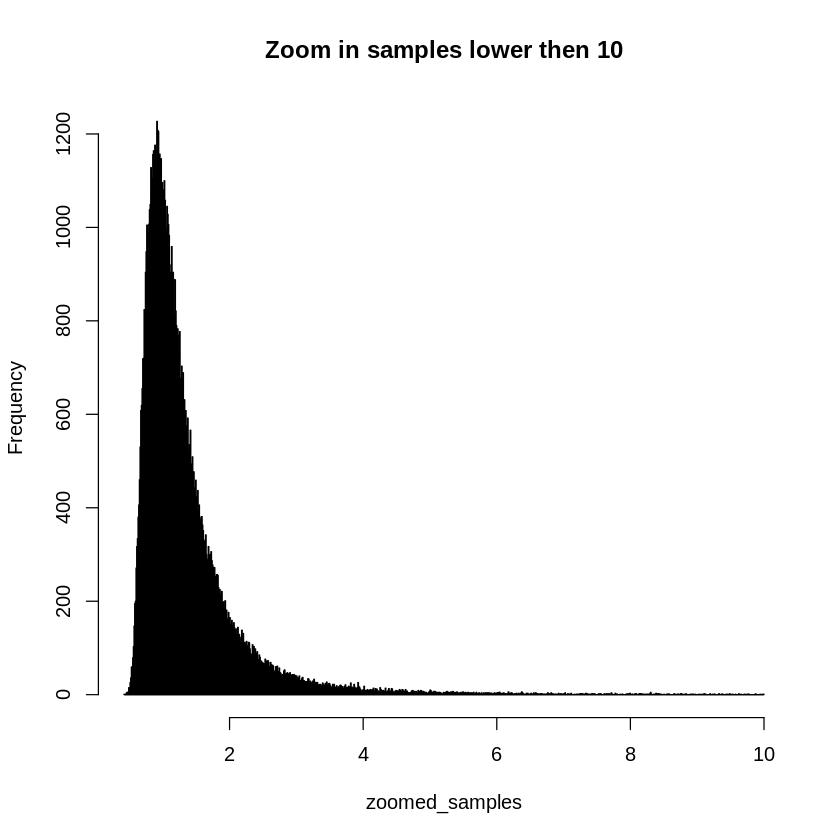

In [5]:
# Set up a 2x2 grid for plots
par(mfrow = c(1, 1))

# Create and plot multiple graphs
hist(samples, breaks = 1000, main = paste("Distribution of", n, 'samples'))
hist(zoomed_samples, breaks = 1000, main = "Zoom in samples lower then 10")

# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


## 1. Fitting of a GPD disribution above some threshold t.

### Choice of threshold t

To choose a correct threshold t we will compute and analyze the stability plot.

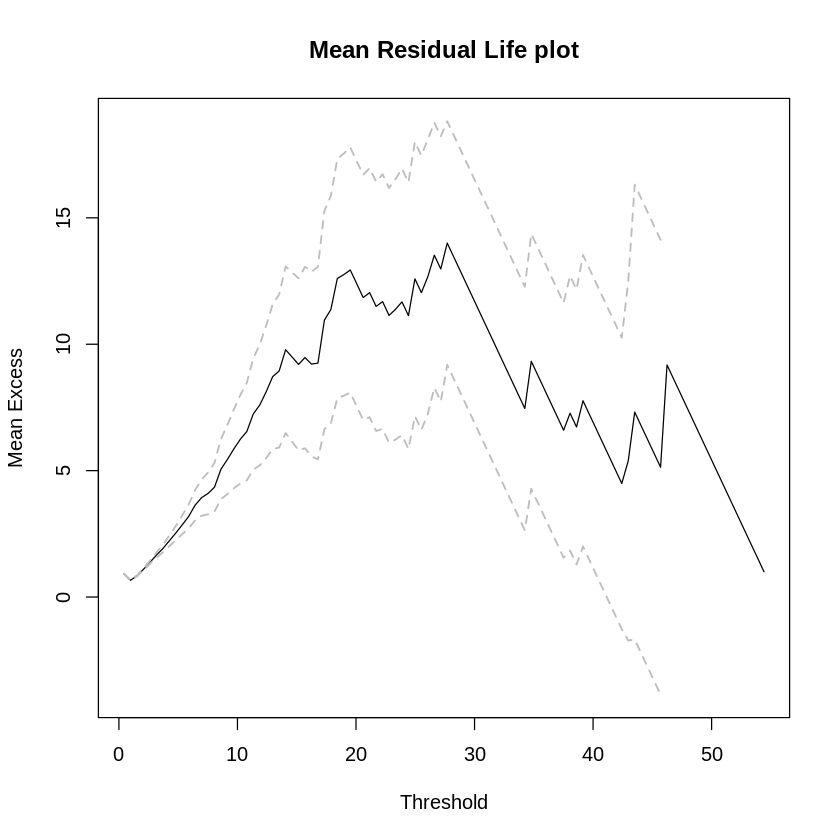

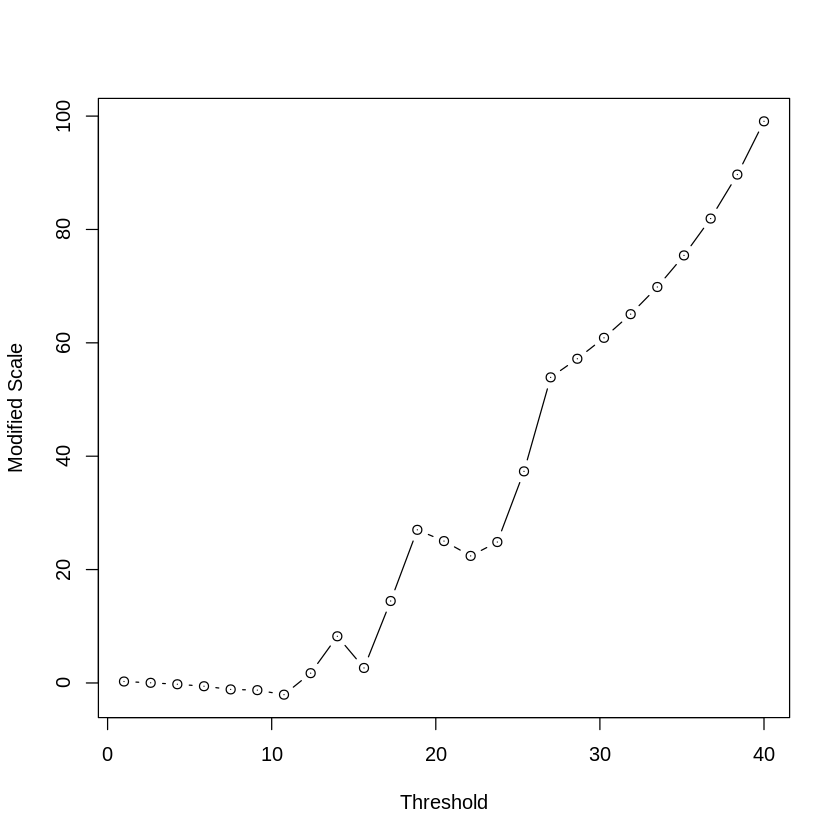

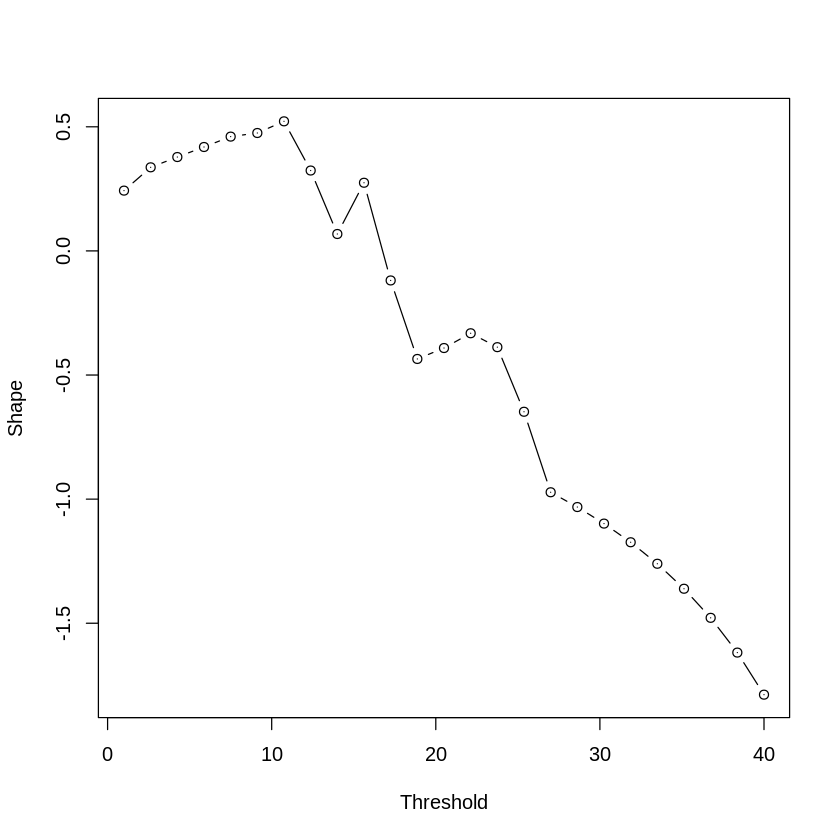

In [6]:
# Set up a 2x2 grid for plots
par(mfrow = c(1, 1))

# Create and plot multiple graphs
mrlplot(samples, main = paste("Mean Residual Life plot"))
tcplot(samples, tlim = c(1,40), std.err = FALSE)
# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


According to the figures, we see that for a threshold $t \in [0,10]$ the modified scale and the shape is constant with respect to t. Moreover, the mean excess is linear with respect to t on this interval. Hence, we can chose $\textbf{t = 5}$ as a threshold, because we also want to have a sufficient number of data to analyze.

In [34]:
### Number of samples above t:
t = 5
excess_samples = samples[samples > t]
cat("Number of excess in our data:", length(excess_samples), '\n')
proportion <- length(excess_samples) / length(samples)
cat("Proportion of the excess in our data: ", proportion, "\n")

Number of excess in our data: 819 
Proportion of the excess in our data:  0.00819 


### Fit a GPD on the values above a threshold t = 5

In [35]:
fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
#the mle parameters will be stored in fp$estimate
fp


fevd(x = samples, threshold = t, type = "GP", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  1531.816 


 Estimated parameters:
    scale     shape 
1.6029843 0.3984815 

 Standard Error Estimates:
     scale      shape 
0.09303087 0.04838430 

 Estimated parameter covariance matrix.
             scale        shape
scale  0.008654743 -0.002661962
shape -0.002661962  0.002341040

 AIC = 3067.631 

 BIC = 3077.047 

In [36]:
scale = as.numeric(fp$results$par['scale'])
shape = as.numeric(fp$results$par['shape'])
cat('scale:', scale, 'shape:', shape)

scale: 1.602984 shape: 0.3984815

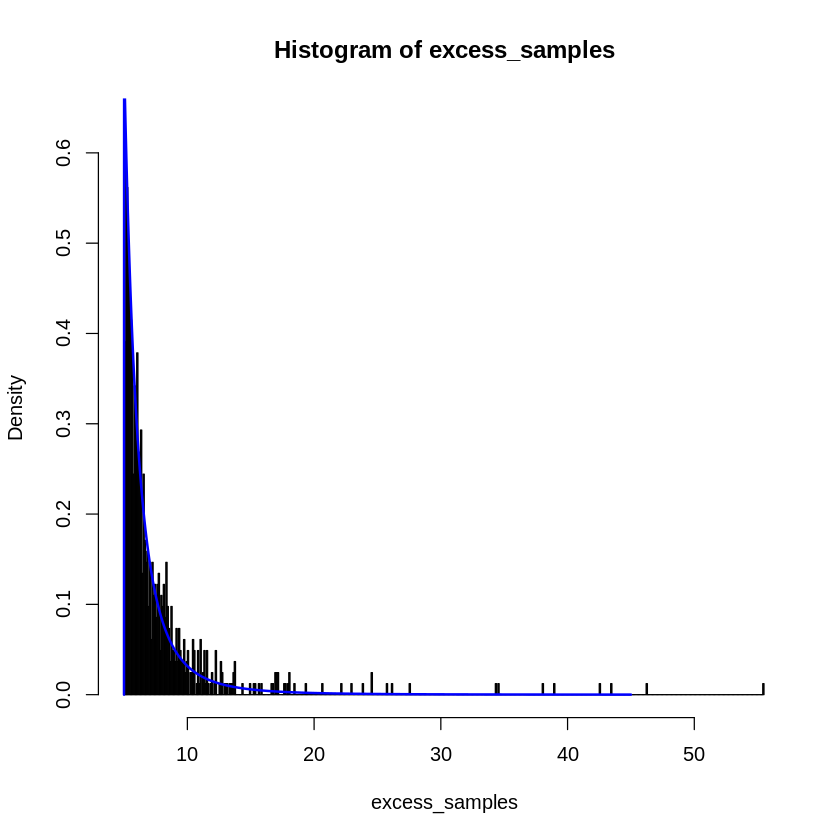

In [37]:
x <- seq(0, 40, by = 0.01)
density <- dgpd(x, shape = 0.3563488693963221, scale = 1.4117778462316397)
hist(excess_samples, breaks = 500, freq = FALSE)
lines(x  + t, density, type = "l", col = "blue", lwd = 2, xlab = "X", ylab = "Density",
     main = "Pareto Density Plot")

## 2. Estimate the quantile of the distribution of the $X_i$ at level p

In [40]:
p <- 1 - 5e-4

p_above_t = length(excess_samples) / length(samples)

z = t + scale * (1/shape) * ((p_above_t/(1 - p)) ** shape - 1)
cat('z:', z)

z: 13.23479

In [41]:
print(length(samples[samples > z]) / length(samples))

[1] 0.00046


By computing the real value of the quantile, using the inverse of the cdf of the Fréchet distribution, we obtain $z = 12.598$ so our estimate is close to the real value.

## 3. Variability of the quantile estimator based on a Monte-Carlo approximation

In [42]:
N_expe <- 100
true_quantile <- true_quantile <- qgev(0.9995, loc = loc_real, scale = scale_real, shape = shape_real)
quantile_estimates <- numeric(N_expe)
quantile_mse <- numeric(N_expe)

for (i in 1:N_expe) {
  samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)
  fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
  scale = as.numeric(fp$results$par['scale'])
  shape = as.numeric(fp$results$par['shape'])
  p_above_t = length(samples[samples > t]) / length(samples)
  z = t + scale * (1/shape) * ((p_above_t/(1 - p)) ** shape - 1)
  quantile_estimates[i] <- z
  quantile_mse[i] <- (quantile_estimates[i] - true_quantile)^2
}

quantile_estimates

[1] 11.94036 13.21915 12.53698 12.99842 12.21512 12.32297 11.92805 12.71381
  [9] 12.91056 13.09554 12.64308 12.65425 13.00217 12.57693 12.96894 12.07439
 [17] 13.14787 12.36888 12.81528 12.82777 12.41618 12.60277 11.86140 12.67690
 [25] 11.55195 12.77622 11.96303 12.09968 13.13859 11.83847 12.95881 12.51280
 [33] 12.64926 13.11256 12.94456 12.17927 12.80147 12.34978 12.34955 12.77806
 [41] 12.62363 12.67407 12.23719 12.15283 12.00084 13.10587 12.43772 12.92898
 [49] 12.33247 12.35562 12.96333 13.15050 12.40709 12.92095 11.61357 11.91317
 [57] 11.81851 12.78623 12.77767 12.05396 12.49527 12.75251 12.35846 12.00675
 [65] 11.67227 12.37336 12.44377 12.22236 13.53350 11.76986 13.08367 12.22267
 [73] 13.48119 11.63458 11.86865 12.50644 12.72290 12.57225 12.49284 12.72548
 [81] 11.74508 12.46654 12.40181 12.19473 11.79543 12.67273 13.10388 13.62939
 [89] 12.13215 11.61938 12.71495 12.95694 11.55555 12.10551 12.04235 12.91647
 [97] 13.92601 13.20103 12.59907 12.51713

In [43]:
cat('average:', mean(quantile_estimates), 'variance:', var(quantile_estimates), '\n')
cat('average of mse:', mean(quantile_mse), 'variance of mse:', var(quantile_mse))


average: 12.51011 variance: 0.2470012 
average of mse: 0.2522841 variance of mse: 0.1060469

In [44]:
lower_quantile <- quantile(quantile_estimates, probs = 0.05)  # 5th percentile
upper_quantile <- quantile(quantile_estimates, probs = 0.95)  # 95th percentile

# Print the results
cat("Lower Quantile (5th percentile): ", lower_quantile, "\n")
cat("Upper Quantile (95th percentile): ", upper_quantile, "\n")

# Calculate the empirical interquantile range
interquantile_range <- upper_quantile - lower_quantile
cat("Empirical Interquantile Range (at level 0.90): ", interquantile_range, "\n")

Lower Quantile (5th percentile):  11.67039 
Upper Quantile (95th percentile):  13.20194 
Empirical Interquantile Range (at level 0.90):  1.531552 


The true quantile belongs to our interval. The estimator seems to be quite relevant in our case.

## 4. Results for another Fréchet shape

#### $\alpha = 1.1$

In [45]:
alpha=1.1
shape_real <- 1/alpha
loc_real <- 1
scale_real <- 1/alpha
n <- 1e5

samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)

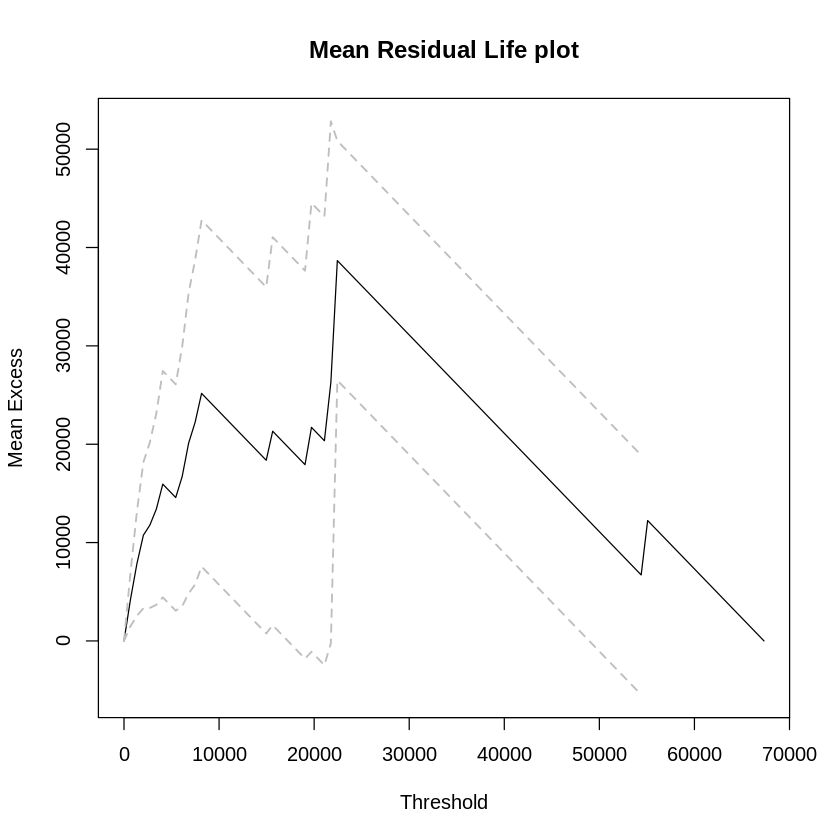

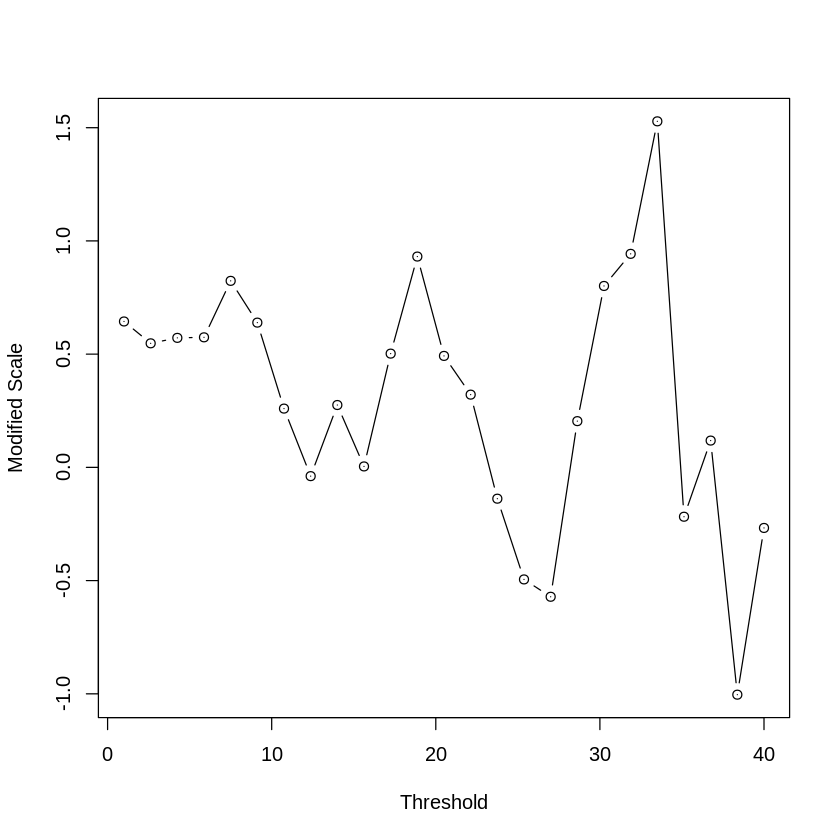

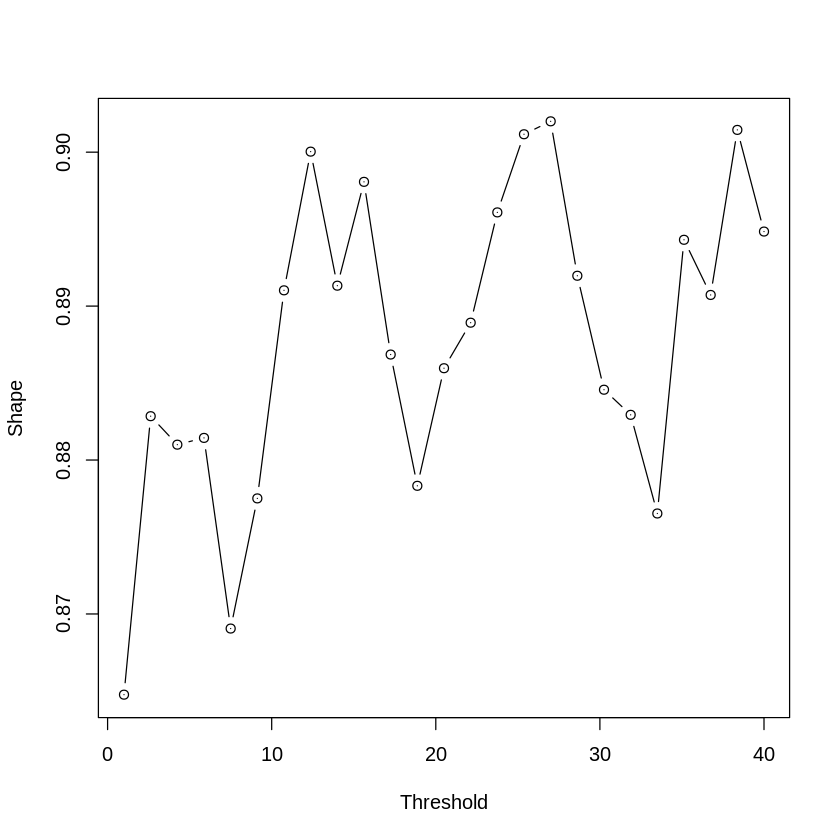

In [46]:
# Set up a 2x2 grid for plots
par(mfrow = c(1, 1))

# Create and plot multiple graphs
mrlplot(samples, main = paste("Mean Residual Life plot"))
tcplot(samples, tlim = c(1,40), std.err = FALSE)
# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


In [47]:
t = 10
cat(length(samples[samples > t]) / length(samples))

0.0774

In [59]:
alpha=1.1
shape_real <- 1/alpha
loc_real <- 1
scale_real <- 1/alpha
n <- 1e5


N_expe <- 100
true_quantile <- qgev(0.9995, loc = loc_real, scale = scale_real, shape = shape_real)
quantile_estimates <- numeric(N_expe)
quantile_mse <- numeric(N_expe)

for (i in 1:N_expe) {
  samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)
  fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
  scale = as.numeric(fp$results$par['scale'])
  shape = as.numeric(fp$results$par['shape'])
  p_above_t = length(samples[samples > t]) / length(samples)
  z = t + scale * (1/shape) * ((p_above_t/(1 - p)) ** shape - 1)
  quantile_estimates[i] <- z
  quantile_mse[i] <- (quantile_estimates[i] - true_quantile)^2
}

cat('average of mse:', mean(quantile_mse), 'variance of mse:', var(quantile_mse), 'true quantile:', true_quantile, 'quantile estimated:', mean(quantile_estimates), 'ratio standard deviation over true quantile:', sqrt(var(quantile_mse))/true_quantile )

average of mse: 8207.679 variance of mse: 47723799 true quantile: 1001.931 quantile estimated: 920.069 ratio standard deviation over true quantile: 6.89493

In [56]:
sqrt(4)

[1] 2

#### $\alpha = 10$

In [49]:
shape_real <- 1/10
loc_real <- 1
scale_real <- 1/10
n <- 1e5

samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)

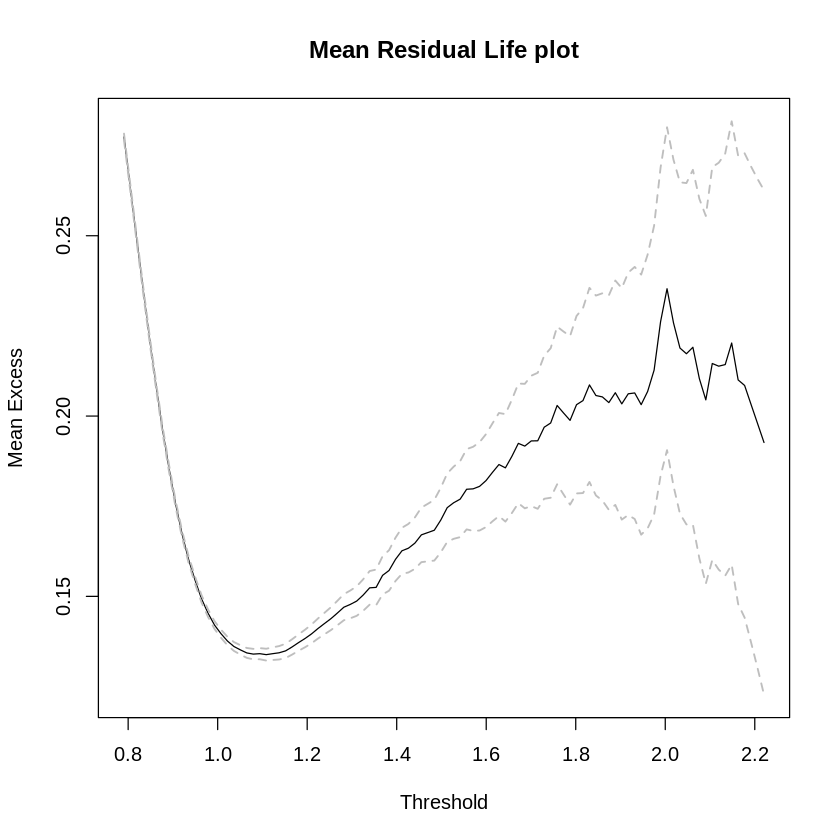

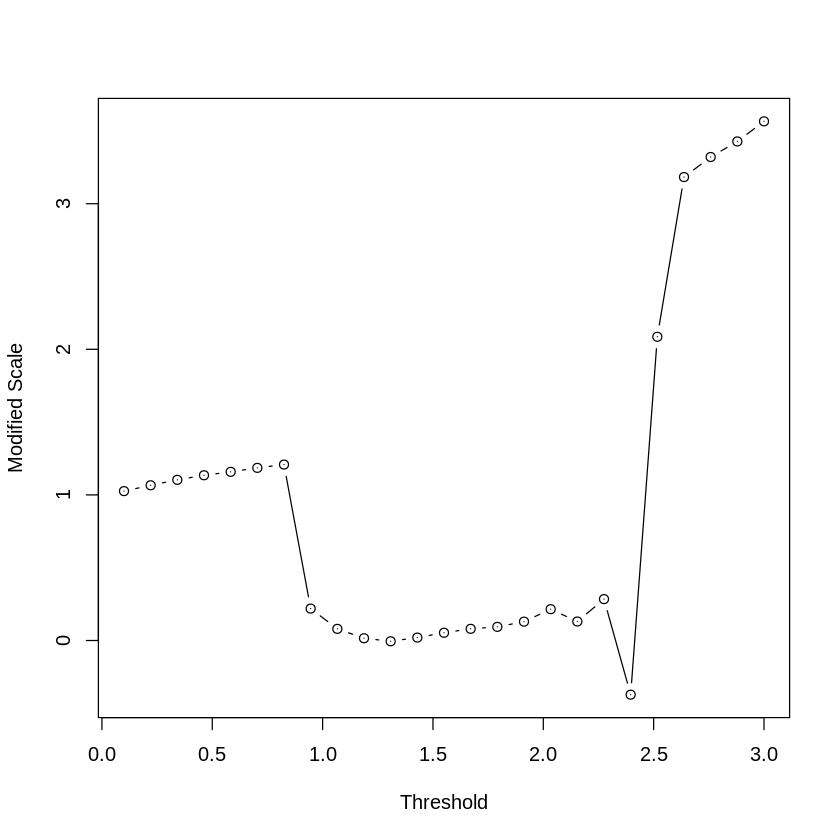

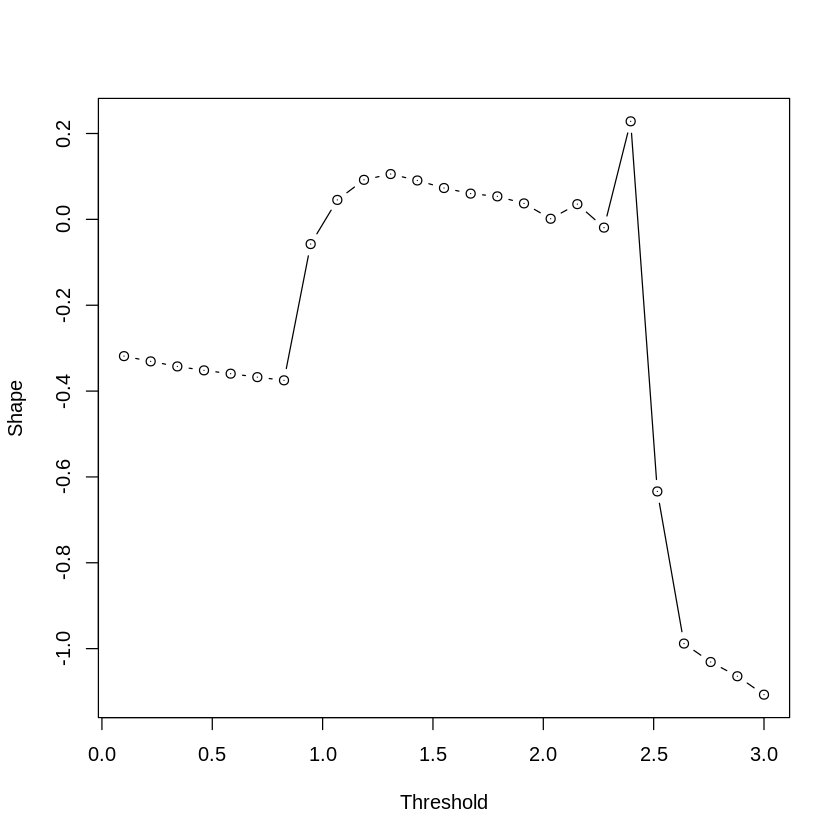

In [50]:
# Set up a 2x2 grid for plots
par(mfrow = c(1, 1))

# Create and plot multiple graphs
mrlplot(samples, main = paste("Mean Residual Life plot"))
tcplot(samples, tlim = c(0.1,3), std.err = FALSE)
# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


In [51]:
t = 1.3
cat(length(samples[samples > t]) / length(samples))

0.06851

In [60]:
N_expe <- 100
true_quantile <- qgev(0.9995, loc = loc_real, scale = scale_real, shape = shape_real)
quantile_estimates <- numeric(N_expe)
quantile_mse <- numeric(N_expe)

for (i in 1:N_expe) {
  samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)
  fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
  scale = as.numeric(fp$results$par['scale'])
  shape = as.numeric(fp$results$par['shape'])
  p_above_t = length(samples[samples > t]) / length(samples)
  z = t + scale * (1/shape) * ((p_above_t/(1 - p)) ** shape - 1)
  quantile_estimates[i] <- z
  quantile_mse[i] <- (quantile_estimates[i] - true_quantile)^2
}

cat('average of mse:', mean(quantile_mse), 'variance of mse:', var(quantile_mse), 'true quantile:', true_quantile, 'quantile estimated:', mean(quantile_estimates), 'ratio standard deviation over true quantile:', sqrt(var(quantile_mse))/true_quantile )

average of mse: 9725.345 variance of mse: 64590983 true quantile: 1001.931 quantile estimated: 914.6882 ratio standard deviation over true quantile: 8.021366

Our estimator performs better with $\alpha = 10$, and is quite relevant for $\alpha = 3$, however is really bad for $\alpha = 1.1$.
We see with these results that the quality of our estimator tends to greatly decrease when alpha gets close to 1, and increase when alpha increases.